# Reference length measurements
Measurements are needed, to allow for a correct model calibration (and validation). The data we use (only long term date we have for the Upper Grindelwald Glacier) are length change records.

In this script I compare two different datasets (*Leclercq* and *glamos.ch*). In a second step, I convert the length change measurements into values of absolute glacier length.

## Compare length records
So far I used the *Leclercq* length records, but Fabi thinks the *glamos.ch* data is better curated. Let's see if there is even a difference...

In [87]:
# import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import my libs
import sys
sys.path.append('../code/')
import utils

In [88]:
# read file
path = '../raw_data/length_data/glamos_length_change.csv'
date_parser = lambda d: pd.datetime.strptime(d, '%Y-%m-%d')
glamos_data = pd.read_csv(path, skiprows=5, header=[0,1,2], sep=';', parse_dates=[2,4], date_parser=date_parser)
glamos_data.head()

,glacier name,glacier id,start date of observation,quality of start date,end date of observation,quality of end date,length change,elevation of glacier tongue,observer
,Unnamed: 0_level_1,(according to Swiss Glacier Inventory),date_start,x = date not exactly known,date_end,x = date not exactly known,dL,h_min,Unnamed: 8_level_1
,Unnamed: 0_level_2,Unnamed: 1_level_2,yyyy-mm-dd (ISO 8601),Unnamed: 3_level_2,yyyy-mm-dd (ISO 8601),Unnamed: 5_level_2,m,m asl.,Unnamed: 8_level_2
0,Silvrettagletscher,A10g/05,1956-09-01,x,1957-09-01,x,-8.0,None,-
1,Silvrettagletscher,A10g/05,1957-09-01,x,1958-09-01,x,-9.0,None,-
2,Silvrettagletscher,A10g/05,1958-09-01,x,1959-09-01,x,-16.0,None,-
3,Silvrettagletscher,A10g/05,1959-09-01,x,1960-09-01,x,-3.0,None,-
4,Silvrettagletscher,A10g/05,1960-09-01,x,1961-09-01,x,-10.0,None,-


In [89]:
# drop column names
glamos_data.columns = glamos_data.columns.droplevel([1,2])
glamos_data.head()

,glacier name,glacier id,start date of observation,quality of start date,end date of observation,quality of end date,length change,elevation of glacier tongue,observer
0,Silvrettagletscher,A10g/05,1956-09-01,x,1957-09-01,x,-8.0,None,-
1,Silvrettagletscher,A10g/05,1957-09-01,x,1958-09-01,x,-9.0,None,-
2,Silvrettagletscher,A10g/05,1958-09-01,x,1959-09-01,x,-16.0,None,-
3,Silvrettagletscher,A10g/05,1959-09-01,x,1960-09-01,x,-3.0,None,-
4,Silvrettagletscher,A10g/05,1960-09-01,x,1961-09-01,x,-10.0,None,-


In [90]:
# select the Upper Grindelwald Glacier
grindel_glamos = (glamos_data[glamos_data['glacier name'] == 'Oberer Grindelwaldgletscher']).copy()

In [91]:
# get columns of interest
length_glamos = (grindel_glamos[['end date of observation','length change']]).copy()
length_glamos.columns = ['years', 'glamos']
# add years as index
length_glamos.index = length_glamos.years.dt.strftime('%Y').astype('int64')
length_glamos.drop('years', axis=1, inplace=True)
# compute cumulated length change
length_glamos = length_glamos.cumsum()
length_glamos.head()

,glamos
years,
1880,-1.0
1881,29.0
1894,80.0
1895,90.0
1896,87.0


In [92]:
# get leclercq length records
length_lec = utils.get_leclercq_length('11.01270', column='leclercq')
length_lec.head()

,leclercq
years,
1593,820
1600,820
1620,820
1640,570
1679,120


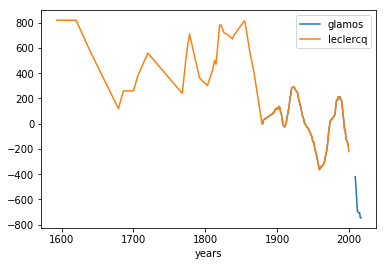

In [93]:
# combine both datasets
length = pd.concat([length_glamos, length_lec], axis=1)
length.plot()

In [94]:
# compute differences
length.dropna().glamos.equals(length.dropna().leclercq)

True

As we see, the GLAMOS and Leclercq length data are equal for the Oberen Grindelwald Gletscher.

In [95]:
# store to file
fn = '/Users/oberrauch/work/grindelwald/data/length_ref_glamos.csv'
length_glamos.to_csv(fn)

## Get 2003 reference length
The records show (relative) glacier length change, while to model results show absolute glacier length. Hereafter, I try to convert the measurements into absolute values of glacier length. The problem is, that there is a gap in the data from 1999 up to 2009. This is especially problematic, since the outline we use is from 2003.

In [1]:
# plot glamos.ch length record
length_glamos.plot(marker='.')

NameError: name 'length_glamos' is not defined

In [11]:
# look at points around 2003
year_of_interest = 2003
window_size = 20
length_glamos.loc[year_of_interest-window_size/2:year_of_interest+window_size/2]

,glamos
years,
1993,19.0
1994,-43.0
1995,-50.0
1996,-120.0
1997,-130.0
1998,-145.0
1999,-170.0
2009,-420.0
2012,-695.0


There is a big data gap between 1999 and 2009 (or even 2012). Around that time the lower part of the glacier (below the icefall) seperated from the accumulation area. Therefore the measured length does not adequately represent the OGGM glacier length, where no seperation happend...

Hence, we need a different approach to identify an estimated glacier length in 2003.

**Best fitting curve based on 1996 - 1999**

In [12]:
length_glamos.loc[1996:1999].diff()

,glamos
years,
1996,NaN
1997,-10.0
1998,-15.0
1999,-25.0


In [13]:
my_length_diff = -10+np.cumsum(np.arange(0,-7*5,-5))
my_length = np.cumsum(my_length_diff)-120
my_length = pd.Series(my_length, index=np.arange(1997, 1997+my_length_diff.size))

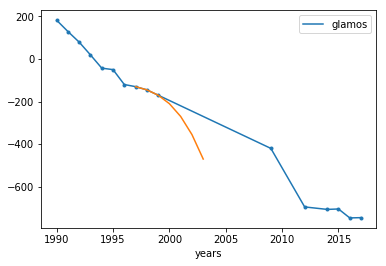

In [14]:
length_glamos.loc[1990:].plot(marker='.')
my_length.plot()

Well... that didn't work as planned.

**Linear interpolation based on `n` years before 1999**

In [15]:
n = 4
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -30.0 m per year


In [16]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -290.0 m


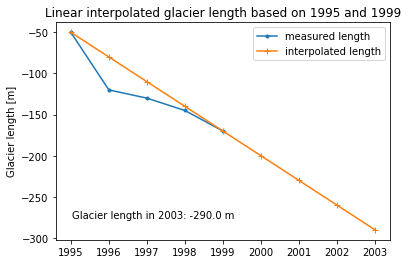

In [17]:
length_glamos.loc[t0:2005].plot(marker='.', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels, ['measured length', 'interpolated length'])
text = 'Glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.1, text, transform=ax.transAxes);

In [18]:
n = 5
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -25.4 m per year


In [19]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -271.6 m


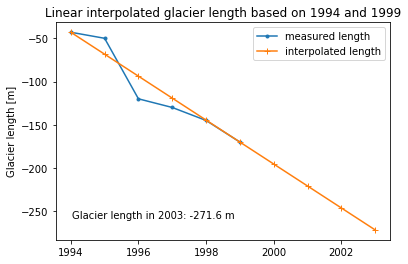

In [20]:
length_glamos.loc[t0:2005].plot(marker='.', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels, ['measured length', 'interpolated length'])
text = 'Glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.1, text, transform=ax.transAxes);

In [21]:
n = 10
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -36.1 m per year


In [22]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -314.4 m


In [100]:
# add years without data points
length_tmp = length_glamos.loc[t0:].copy()
new_index = np.arange(min(length_tmp.index), max(length_tmp.index)+1)
length_tmp = length_tmp.reindex(new_index)

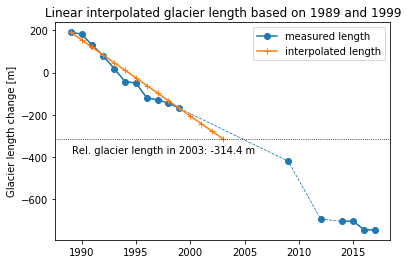

In [189]:
length_glamos.loc[t0:].plot(ls='--', lw=0.8, legend=False)
length_tmp.plot(c='C0', ax=plt.gca(), marker='o', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length change [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[1:], ['measured length', 'interpolated length'])
text = 'Rel. glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.4, text, transform=ax.transAxes);
ax.axhline(my_length.loc[2003], ls=':', lw='0.8', c='k')

# store
path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/length_interp.pdf'
plt.savefig(path, bbox_inches='tight')

I'll use the interpolation based on the 10 years befor 1999, hence an average length change of -36.1 m per year.

**Get RGI value for 2003**

In [25]:
from oggm import utils, cfg
from oggm.core import gis
from oggm import GlacierDirectory

In [26]:
## Initialize
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/tmp_wdir/'
cfg.PATHS['working_dir'] = wdir

2019-06-14 19:21:19: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [27]:
# using intersects
cfg.PARAMS['use_intersects'] = True

## Preprocessing
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = utils.get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]

# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

# prepare glacier directory
gdir = GlacierDirectory(rgi_entity, reset=True)
# define glacier region
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)

2019-06-14 19:21:20: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-06-14 19:21:21: oggm.core.gis: (RGI60-11.01270) glacier_masks


In [28]:
from oggm.core import centerlines
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-06-14 19:21:21: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-06-14 19:21:21: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-06-14 19:21:22: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-06-14 19:21:22: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-06-14 19:21:22: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-06-14 19:21:24: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-06-14 19:21:25: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-06-14 19:21:26: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


In [29]:
from oggm.core import climate
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

# instance mass balance model using the historic climate file
from oggm.core import massbalance
mb_model = massbalance.PastMassBalance(gdir)

2019-06-14 19:21:26: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-06-14 19:21:29: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-06-14 19:21:29: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-06-14 19:21:29: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


In [30]:
from oggm.core import inversion
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

# finalize the preprocessing
from oggm.core import flowline
flowline.init_present_time_glacier(gdir)

2019-06-14 19:21:29: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-06-14 19:21:29: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-06-14 19:21:29: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output
2019-06-14 19:21:29: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


In [31]:
# read needed file
ci = gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                y0=ci['baseline_hydro_yr_0'])

In [138]:
rgi_length_2003 = model.length_m
rgi_length_2003

6136.0

## Compute absolute length values

In [139]:
# add absolute value of 20003
length_abs = length_glamos.copy() + rgi_length_2003 - my_length[2003]
# change column name
length_abs.columns = ['length_ref']
# add years with missing data to index/DataFrame
years_idx = np.arange(min(length_abs.index), max(length_abs.index)+1)
length_abs = length_abs.reindex(years_idx)

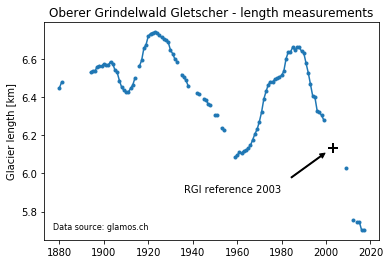

In [188]:
(length_abs/1e3).plot(marker='.', legend=False)

# make plot fanicer
ax = plt.gca()
title = 'Oberer Grindelwald Gletscher - length measurements'
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [km]')
ax.plot(2003, rgi_length_2003/1e3, marker='+', markersize=10, markeredgewidth=2, c='k')
ax.annotate('RGI reference 2003', xy=(2003, rgi_length_2003/1e3),
            xytext=(1980, 5.9), ha='right',
            arrowprops={'width': 1, 'headwidth': 5, 'headlength': 5, 'shrink': 0.15, 'facecolor':'k'})
ax.text(0.025, 0.05, 'Data source: glamos.ch', fontsize=8, transform=ax.transAxes)

# store
path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/length_time_series.pdf'
plt.savefig(path, bbox_inches='tight')

In [132]:
# get years with missing data
missing_years = length_abs[length_abs.isnull().any(axis=1)].index
missing_years

Int64Index([1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
            1893, 1915, 1934, 1939, 1940, 1941, 1944, 1949, 1952, 1955, 1956,
            1957, 1958, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2010, 2011, 2013],
           dtype='int64', name='years')

**Missing years**:

- period 1: 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893
- period 2: 1915 (WW1)
- period 3: 1934, 1939, 1940, 1941, 1944, 1949, 1952, 1955, 1956, 1957, 1958 (WW2)
- perido 4: 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2010, 2011, 2013 (2009 & 2012 IS GIVEN!)


In [52]:
# store to file
fn = '/Users/oberrauch/work/grindelwald/data/length_ref_abs.csv'
length_abs.to_csv(fn)

## Sandbox: visualizing the bed shape along the flowline...

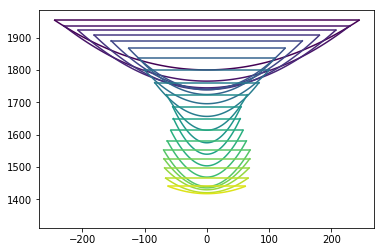

In [230]:
# get main flowline
fl = fls[-1]
indices = np.arange(40,60)
cmap = plt.get_cmap('viridis', indices.size)

# specify index
for i, idx in enumerate(indices):
    # get shape parameter, width and ice thickness
    shape = fl.bed_shape[idx]
    width = fl.widths_m[idx]
    bed_h = fl.bed_h[idx]
    surf_h = fl.surface_h[idx]
    # define x coordinates
    half_width = width/2
    x = np.linspace(-half_width, half_width, 101)
    # compute bed shape
    y = shape * x**2
    # plot
    plt.plot(x,y+bed_h, c=cmap(i))
    plt.plot([-half_width, half_width], [surf_h, surf_h], c=cmap(i))

In [239]:
x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [248]:
fl.line.xy

(array('d', [103.0, 102.0, 101.3731312579452, 99.95891769557211, 98.54470413319902, 97.13049057082593, 97.0, 97.0, 97.0, 97.0, 95.65759977977154, 94.24338621739845, 92.82917265502536, 91.41495909265227, 90.00074553027918, 88.58653196790608, 87.17231840553299, 85.7581048431599, 84.3438912807868, 82.92967771841371, 81.51546415604062, 80.10125059366753, 78.68703703129444, 77.27282346892135, 75.85860990654825, 74.44439634417516, 72.49640610929214, 70.49640610929214, 68.49640610929214, 66.49640610929214, 64.85705484765774, 63.05266096893242, 61.323106712584774, 59.59355245623713, 57.62911905544893, 56.21490549307584, 54.80069193070275, 53.386478368329655, 51.42435862680071, 49.69480437045306, 47.69480437045306, 45.965250114105416, 43.96687732670056, 42.55266376432747, 40.63179310640616, 38.662419980077274, 36.84111681487274, 35.42690325249965, 34.01268969012656, 32.598476127753464, 31.18426256538037, 29.770049003007276, 28.948745837802743, 27.534532275429648, 26.12031871305655, 25.299015547

In [305]:
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [307]:
def planeEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xy'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xy'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

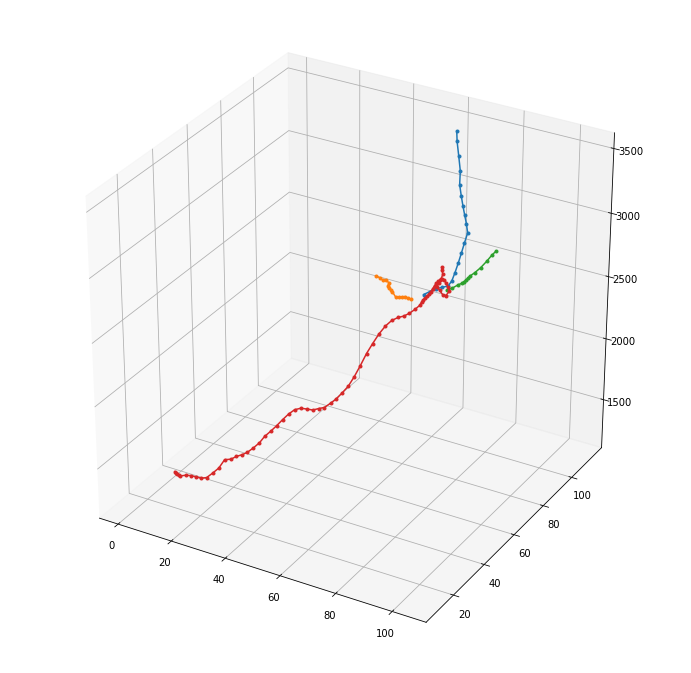

In [308]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')

for fl in fls[:]:
    fl_x, fl_y = fl.line.xy
    ax.plot(fl_x, fl_y, fl.bed_h, marker='.')
    
ax.invert_yaxis()
planeEqual3D(ax)

In [255]:
%matplotlib inline

In [284]:
from oggm import graphics

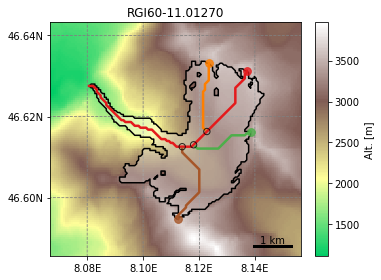

In [285]:
graphics.plot_centerlines(gdir)

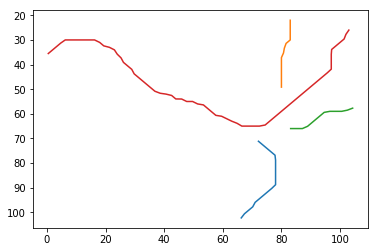

In [290]:
for fl in fls:
    fl_x, fl_y = fl.line.xy
    plt.plot(fl_x, fl_y)
    
plt.gca().invert_yaxis()

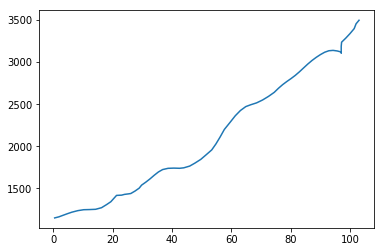

In [278]:
plt.plot(fl_x, fl.bed_h)

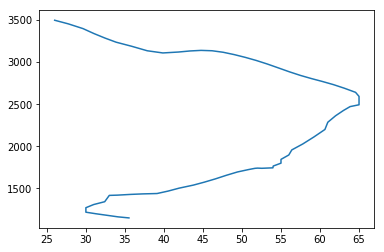

In [279]:
plt.plot(fl_y, fl.bed_h)

'#bcbd22'